In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from libs.MSCTDdataset import MSCTD
from torch.utils.data import Dataset, DataLoader
from libs.transforms import Compose,toTensor,resize
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import PIL 
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sb


# Pre-Processing 

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user01/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
transforms = Compose([resize(dstsize=(224,224))])

root_dir = '.'

training_data_single = MSCTD(
        mode='train', 
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

valid_data_single = MSCTD(
        mode='validation',
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

test_data_single = MSCTD(
        mode='test',
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

In [5]:
batch_size = 32
train_dataloader = DataLoader(training_data_single, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data_single, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_single, batch_size=batch_size, shuffle=True)

In [6]:
# training Dataframe
training_data_sentiment = [int(i) for i in training_data_single.sentiment]
training_data = pd.DataFrame( data = {'sentences': training_data_single.english_text , 'sentiment': training_data_sentiment})

# training Dataframe
valid_data_sentiment = [int(i) for i in valid_data_single.sentiment]
valid_data = pd.DataFrame( data = {'sentences': valid_data_single.english_text , 'sentiment': valid_data_sentiment})

# test Dataframe
test_data_sentiment = [int(i) for i in test_data_single.sentiment]
test_data = pd.DataFrame( data = {'sentences': test_data_single.english_text , 'sentiment': test_data_sentiment})

In [7]:
# pre-processing function
def prep(review):
    
    # Remove non-letters
    review = re.sub("[^a-zA-Z]", " ", review)
    
    # Lower case
    review = review.lower()

    # Remove extra spaces
    review = re.sub(' +', ' ', review)
    
    # Tokenize to each word.
    token = nltk.word_tokenize(review)

    # Remove Stopwords
    stop = stopwords.words('english')
    review = [w for w in token if w not in stop]

    # Stemming
    review = [nltk.stem.SnowballStemmer('english').stem(w) for w in review]


    # lemmatization 
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review]

    # Join the words back into one string separated by space, and return the result.
    return " ".join(review)
    

In [8]:
training_data['clean'] = training_data['sentences'].apply(prep)
valid_data['clean'] = valid_data['sentences'].apply(prep)
test_data['clean'] = test_data['sentences'].apply(prep)

In [9]:
training_data

,sentences,sentiment,clean
0,Okay. I'm confused.,0,okay confus
1,"You don't care if I go to Paris with Jane,",0,care go pari jane
2,"I'm sorry. I have to tell you something,",1,sorri tell someth
3,I have to go.,1,go
4,I'm an accessory to murder.,1,accessori murder
...,...,...,...
20235,"Hey, this is for charity.",2,hey chariti
20236,You know you're taking those jeans out of the ...,0,know take jean hand
20237,"You know they're not getting the actual jeans,...",0,know get actual jean right luke
20238,"Oh. Right. Well, then how about a donation?",2,oh right well donat


In [10]:
valid_data

,sentences,sentiment,clean
0,He diagnosed Andy with growing pains.,0,diagnos andi grow pain
1,"But, you know, I grew up,",0,know grew
2,Your pain is dramatic to me.,1,pain dramat
3,Andy. your mom's right.,0,andi mom right
4,It's a good thing that you came.,0,good thing came
...,...,...,...
5058,Your van crashed.,1,van crash
5059,"No one was hurt, but we need to get you examined.",2,one hurt need get examin
5060,Come on.,1,come
5061,I must have fallen asleep at the wheel for a s...,2,must fallen asleep wheel second


In [11]:
test_data

,sentences,sentiment,clean
0,With this asshole?,1,asshol
1,"Two guys walk in, one walks out.",1,two guy walk one walk
2,"I'm not happy about it either, okay? At all.",1,happi either okay
3,"But, for now, it's done.",1,done
4,You're on admin leave until they make a determ...,0,admin leav make determin batteri
...,...,...,...
5062,"Han, you stand there and try to look smart.",2,han stand tri look smart
5063,"Ah. I'm already Asian. So, done.",2,ah alreadi asian done
5064,"Wow, this brings me back.",0,wow bring back
5065,"I had a seat at the popular table,",0,seat popular tabl


# A) Word Representation

## Part 1: tf-idf vectors

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from wordcloud import WordCloud, STOPWORDS


In [29]:
tv = TfidfVectorizer(ngram_range = (1,3), sublinear_tf = True, max_features = 40000)

In [30]:
train_tv = tv.fit_transform(training_data['clean'])
test_tv = tv.transform(test_data['clean'])

In [62]:
vocab = tv.get_feature_names_out()
vocab

array(['aaron', 'abdomen', 'abl', ..., 'zuckerberg', 'zup', 'zz'],
      dtype=object)

In [32]:
dist = np.sum(train_tv, axis=0)
checking = pd.DataFrame(dist,columns = vocab)

In [34]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

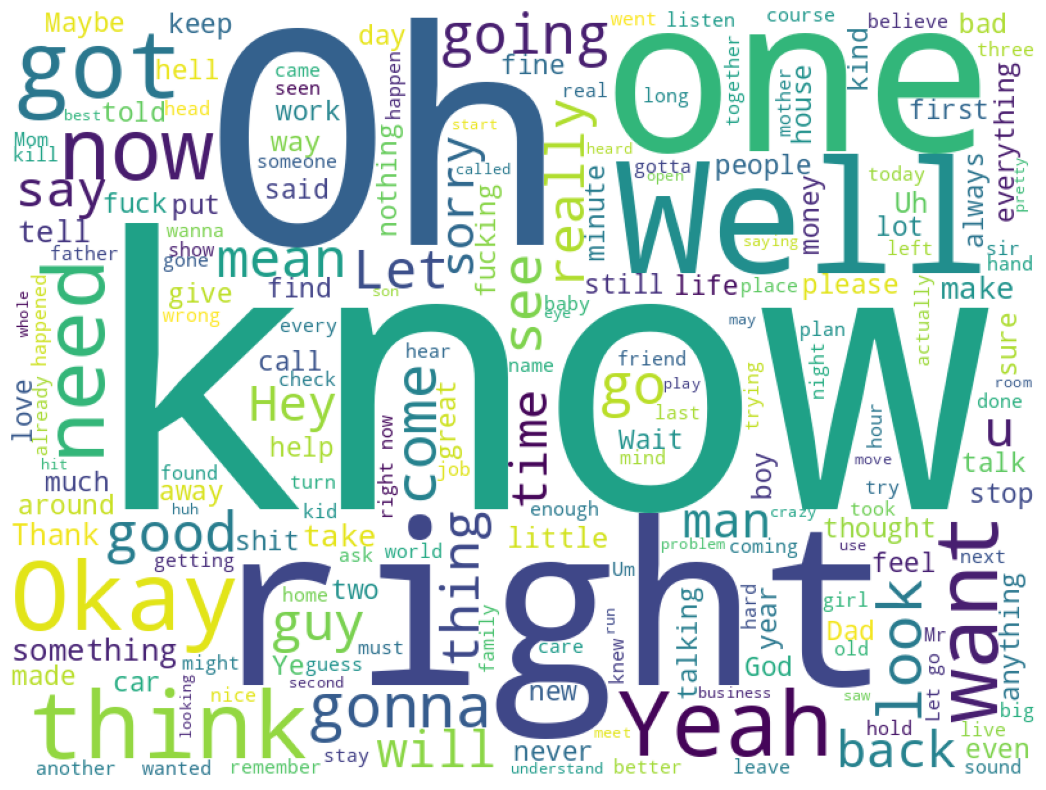

In [36]:
cloud(' '.join(training_data['sentences']))

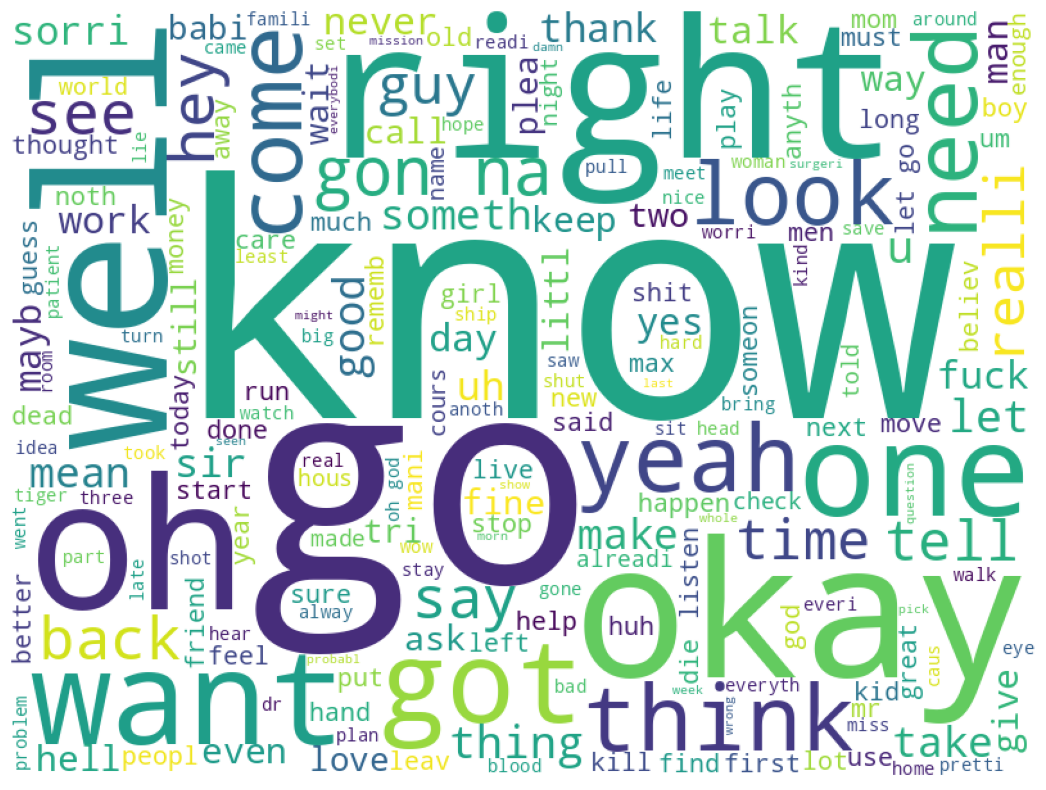

In [37]:
cloud(' '.join(test_data['clean']))

* SVM

In [50]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [51]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.35      0.49      0.41      1298
    negative       0.56      0.54      0.55      2163
    positive       0.53      0.40      0.45      1606

    accuracy                           0.48      5067
   macro avg       0.48      0.47      0.47      5067
weighted avg       0.50      0.48      0.48      5067



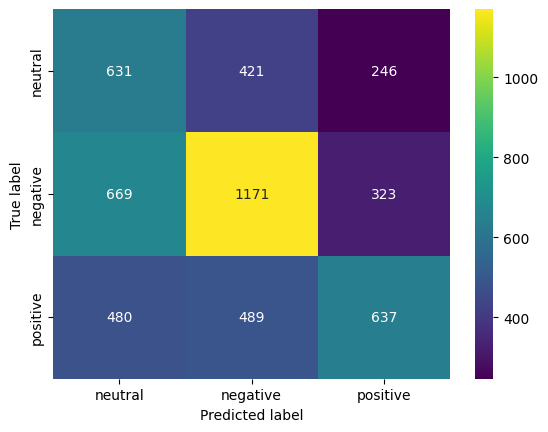

In [52]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [54]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.37      0.51      0.43      1298
    negative       0.56      0.58      0.57      2163
    positive       0.57      0.38      0.45      1606

    accuracy                           0.50      5067
   macro avg       0.50      0.49      0.48      5067
weighted avg       0.52      0.50      0.50      5067



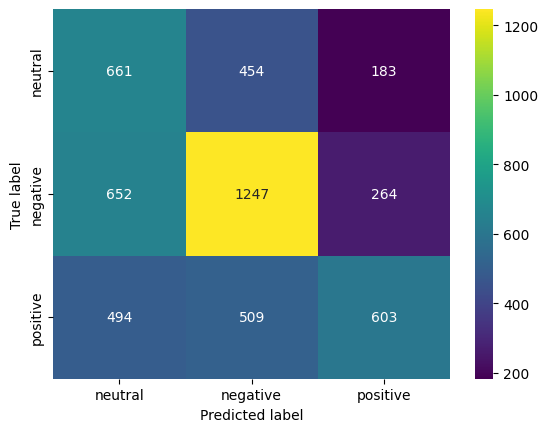

In [55]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* MLP

In [56]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, activation = 'relu', solver='adam', random_state=1)
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [57]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.33      0.48      0.39      1298
    negative       0.54      0.47      0.50      2163
    positive       0.47      0.38      0.42      1606

    accuracy                           0.44      5067
   macro avg       0.45      0.44      0.44      5067
weighted avg       0.46      0.44      0.45      5067



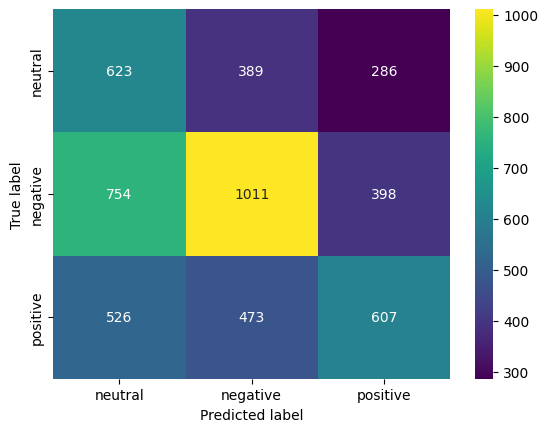

In [58]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 2

# C) Pre-trained Word Representation : GloVe

In [15]:
import torchtext
from libs.glove import GloVe

In [66]:
glove = torchtext.vocab.GloVe(name='6B',dim=50)

.vector_cache/glove.6B.zip: 862MB [07:48, 1.84MB/s]                                
100%|█████████▉| 399999/400000 [00:04<00:00, 92461.46it/s] 


In [16]:
vectorizer = GloVe(glove_dir='.vector_cache/glove.6B.50d.txt')

Xtrain = vectorizer.fit_transform(training_data.clean)
Ytrain = training_data.sentiment

Xtest = vectorizer.transform(test_data.clean)
Ytest = test_data.sentiment

* SVM

In [17]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [18]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.36      0.46      0.41      1298
    negative       0.54      0.62      0.58      2163
    positive       0.56      0.33      0.42      1606

    accuracy                           0.49      5067
   macro avg       0.49      0.47      0.47      5067
weighted avg       0.50      0.49      0.48      5067



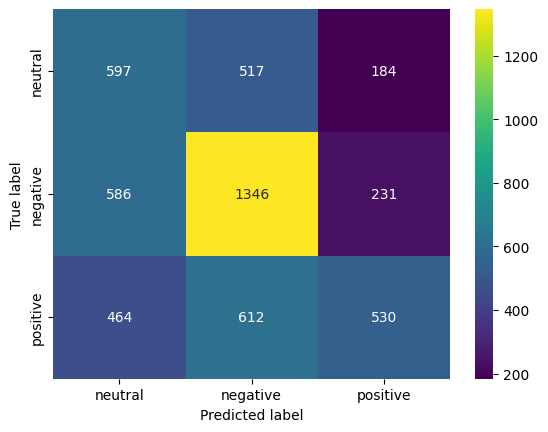

In [19]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [21]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.36      0.46      0.41      1298
    negative       0.55      0.62      0.58      2163
    positive       0.56      0.34      0.42      1606

    accuracy                           0.49      5067
   macro avg       0.49      0.47      0.47      5067
weighted avg       0.50      0.49      0.48      5067



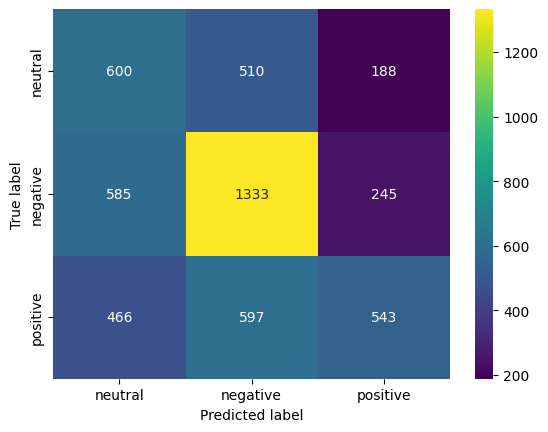

In [22]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* MLP

In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, activation = 'relu', solver='adam', random_state=1)
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [24]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.37      0.46      0.41      1298
    negative       0.54      0.62      0.58      2163
    positive       0.54      0.33      0.41      1606

    accuracy                           0.49      5067
   macro avg       0.48      0.47      0.47      5067
weighted avg       0.50      0.49      0.48      5067



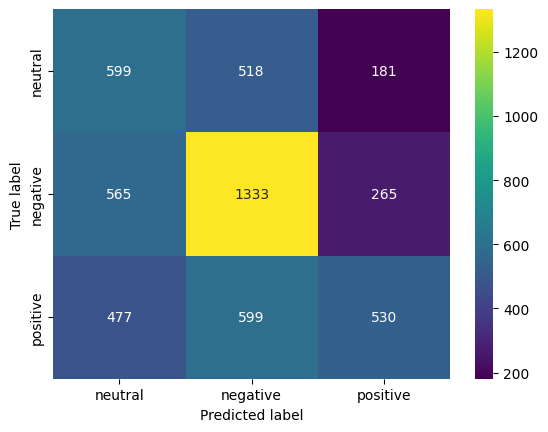

In [25]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Pre-trained Model : Bert


In [12]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import AdamW

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

In [15]:
train_texts = training_data['sentences'].tolist()
train_labels = training_data['sentiment'].tolist()

valid_texts = valid_data['sentences'].tolist()
valid_labels = valid_data['sentiment'].tolist()

test_texts = test_data['sentences'].tolist()
test_labels = test_data['sentiment'].tolist()

In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [17]:
import torch

class MSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MSDataset(train_encodings, train_labels)
valid_dataset = MSDataset(valid_encodings, valid_labels)
test_dataset = MSDataset(test_encodings, test_labels)

In [18]:
from transformers import AutoModel, AdamW
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self):
    super(TextClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained('bert-base-uncased')
    self.fc1 = nn.Linear(768, 32)
    self.fc2 = nn.Linear(32, 3)
    #self.activation = nn.ReLU()
  
  def forward(self, input_ids, attention_mask):
    temp = input_ids
    temp = self.bert(input_ids, attention_mask=attention_mask)[1]
    temp = self.fc1(temp)
    temp = self.fc2(temp)
    return temp

In [19]:
model = TextClassifier()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

learning_rate = 5e-5
optim = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss().to(device)
     

In [21]:
for p in model.bert.parameters():
    p.requires_grad = False

In [22]:
from tqdm import tqdm
def train_loop(epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        for item in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            size_batch = item['labels'].size()[0]
            # Compute prediction and loss
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            avgLoss += loss.item()
            correct = (outputs.argmax(1) == labels).type(torch.float).sum().item()
            avgCorrect += correct
            
            # Backpropagation
            
            loss.backward()
            optimizer.step()
    
            correct = correct / size_batch
            
            tepoch.set_postfix(batch_loss=loss.item(), batch_accuracy=100. * correct)
            
    avgLoss /= len(dataloader)
    avgCorrect /= size
    print(f" -Training Accuracy (Avg) = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.eval()
    with torch.no_grad():
        for item in dataloader:
            # Compute prediction and loss
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            avgLoss += loss_fn(outputs, labels).item()
            avgCorrect += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    avgLoss /= size
    avgCorrect /= size
    print(f" -{error} : Accuracy = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='tensorboard/Bert')

epochs = 50
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_loader, model, loss_func, optim)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_loader, model, loss_func, 'validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 633/633 [00:09<00:00, 66.29batch/s, batch_accuracy=50, batch_loss=1.05]   


 -Training Accuracy (Avg) = 48.6%, Avg loss = 1.025747 

 -validation : Accuracy = 49.4%, Avg loss = 0.032217 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 633/633 [00:09<00:00, 65.76batch/s, batch_accuracy=62.5, batch_loss=0.975]


 -Training Accuracy (Avg) = 50.5%, Avg loss = 1.009475 

 -validation : Accuracy = 49.1%, Avg loss = 0.031711 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 633/633 [00:09<00:00, 65.49batch/s, batch_accuracy=43.8, batch_loss=1.07] 


 -Training Accuracy (Avg) = 51.9%, Avg loss = 0.995435 

 -validation : Accuracy = 50.3%, Avg loss = 0.031451 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 633/633 [00:09<00:00, 65.41batch/s, batch_accuracy=68.8, batch_loss=0.95] 


 -Training Accuracy (Avg) = 52.8%, Avg loss = 0.982619 

 -validation : Accuracy = 52.7%, Avg loss = 0.030924 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 633/633 [00:09<00:00, 65.49batch/s, batch_accuracy=68.8, batch_loss=0.815]


 -Training Accuracy (Avg) = 53.0%, Avg loss = 0.973818 

 -validation : Accuracy = 52.0%, Avg loss = 0.030976 

 Epoch 6 -------------------------------


Epoch 6: 100%|██████████| 633/633 [00:09<00:00, 65.29batch/s, batch_accuracy=56.2, batch_loss=1.03] 


 -Training Accuracy (Avg) = 53.3%, Avg loss = 0.967600 

 -validation : Accuracy = 53.5%, Avg loss = 0.030688 

 Epoch 7 -------------------------------


Epoch 7: 100%|██████████| 633/633 [00:09<00:00, 65.07batch/s, batch_accuracy=62.5, batch_loss=0.806]


 -Training Accuracy (Avg) = 54.0%, Avg loss = 0.960619 

 -validation : Accuracy = 54.1%, Avg loss = 0.030230 

 Epoch 8 -------------------------------


Epoch 8: 100%|██████████| 633/633 [00:09<00:00, 65.05batch/s, batch_accuracy=62.5, batch_loss=0.954]


 -Training Accuracy (Avg) = 54.6%, Avg loss = 0.956751 

 -validation : Accuracy = 54.4%, Avg loss = 0.030096 

 Epoch 9 -------------------------------


Epoch 9: 100%|██████████| 633/633 [00:09<00:00, 65.23batch/s, batch_accuracy=56.2, batch_loss=0.963]


 -Training Accuracy (Avg) = 54.8%, Avg loss = 0.948454 

 -validation : Accuracy = 53.9%, Avg loss = 0.030178 

 Epoch 10 -------------------------------


Epoch 10: 100%|██████████| 633/633 [00:09<00:00, 65.30batch/s, batch_accuracy=50, batch_loss=0.899]  


 -Training Accuracy (Avg) = 55.3%, Avg loss = 0.945485 

 -validation : Accuracy = 54.6%, Avg loss = 0.030034 

 Epoch 11 -------------------------------


Epoch 11: 100%|██████████| 633/633 [00:09<00:00, 65.00batch/s, batch_accuracy=56.2, batch_loss=0.975]


 -Training Accuracy (Avg) = 55.2%, Avg loss = 0.943307 

 -validation : Accuracy = 54.9%, Avg loss = 0.029862 

 Epoch 12 -------------------------------


Epoch 12: 100%|██████████| 633/633 [00:09<00:00, 65.54batch/s, batch_accuracy=62.5, batch_loss=0.83] 


 -Training Accuracy (Avg) = 55.5%, Avg loss = 0.939155 

 -validation : Accuracy = 55.5%, Avg loss = 0.029671 

 Epoch 13 -------------------------------


Epoch 13: 100%|██████████| 633/633 [00:09<00:00, 65.05batch/s, batch_accuracy=62.5, batch_loss=0.889]


 -Training Accuracy (Avg) = 56.2%, Avg loss = 0.933460 

 -validation : Accuracy = 55.2%, Avg loss = 0.029699 

 Epoch 14 -------------------------------


Epoch 14: 100%|██████████| 633/633 [00:09<00:00, 65.26batch/s, batch_accuracy=62.5, batch_loss=0.868]


 -Training Accuracy (Avg) = 56.2%, Avg loss = 0.931755 

 -validation : Accuracy = 55.3%, Avg loss = 0.029592 

 Epoch 15 -------------------------------


Epoch 15: 100%|██████████| 633/633 [00:09<00:00, 64.86batch/s, batch_accuracy=31.2, batch_loss=1.01] 


 -Training Accuracy (Avg) = 56.5%, Avg loss = 0.929612 

 -validation : Accuracy = 55.7%, Avg loss = 0.029556 

 Epoch 16 -------------------------------


Epoch 16: 100%|██████████| 633/633 [00:09<00:00, 65.13batch/s, batch_accuracy=62.5, batch_loss=0.919]


 -Training Accuracy (Avg) = 56.1%, Avg loss = 0.928222 

 -validation : Accuracy = 55.8%, Avg loss = 0.029408 

 Epoch 17 -------------------------------


Epoch 17: 100%|██████████| 633/633 [00:09<00:00, 65.01batch/s, batch_accuracy=50, batch_loss=1.02]   


 -Training Accuracy (Avg) = 56.8%, Avg loss = 0.925383 

 -validation : Accuracy = 55.5%, Avg loss = 0.029548 

 Epoch 18 -------------------------------


Epoch 18: 100%|██████████| 633/633 [00:09<00:00, 64.98batch/s, batch_accuracy=43.8, batch_loss=1.01] 


 -Training Accuracy (Avg) = 56.6%, Avg loss = 0.925501 

 -validation : Accuracy = 56.0%, Avg loss = 0.029505 

 Epoch 19 -------------------------------


Epoch 19: 100%|██████████| 633/633 [00:09<00:00, 64.84batch/s, batch_accuracy=37.5, batch_loss=1.11] 


 -Training Accuracy (Avg) = 57.2%, Avg loss = 0.921677 

 -validation : Accuracy = 55.8%, Avg loss = 0.029370 

 Epoch 20 -------------------------------


Epoch 20: 100%|██████████| 633/633 [00:09<00:00, 64.86batch/s, batch_accuracy=56.2, batch_loss=0.904]


 -Training Accuracy (Avg) = 56.9%, Avg loss = 0.920650 

 -validation : Accuracy = 55.3%, Avg loss = 0.029530 

 Epoch 21 -------------------------------


Epoch 21: 100%|██████████| 633/633 [00:09<00:00, 65.37batch/s, batch_accuracy=50, batch_loss=1.08]   


 -Training Accuracy (Avg) = 57.0%, Avg loss = 0.920831 

 -validation : Accuracy = 56.2%, Avg loss = 0.029295 

 Epoch 22 -------------------------------


Epoch 22: 100%|██████████| 633/633 [00:09<00:00, 65.27batch/s, batch_accuracy=68.8, batch_loss=0.867]


 -Training Accuracy (Avg) = 57.5%, Avg loss = 0.919007 

 -validation : Accuracy = 56.0%, Avg loss = 0.029245 

 Epoch 23 -------------------------------


Epoch 23: 100%|██████████| 633/633 [00:09<00:00, 65.23batch/s, batch_accuracy=68.8, batch_loss=0.816]


 -Training Accuracy (Avg) = 57.2%, Avg loss = 0.919186 

 -validation : Accuracy = 56.3%, Avg loss = 0.029261 

 Epoch 24 -------------------------------


Epoch 24: 100%|██████████| 633/633 [00:09<00:00, 65.23batch/s, batch_accuracy=43.8, batch_loss=0.993]


 -Training Accuracy (Avg) = 57.5%, Avg loss = 0.916277 

 -validation : Accuracy = 56.2%, Avg loss = 0.029249 

 Epoch 25 -------------------------------


Epoch 25: 100%|██████████| 633/633 [00:09<00:00, 65.07batch/s, batch_accuracy=62.5, batch_loss=0.878]


 -Training Accuracy (Avg) = 57.6%, Avg loss = 0.912835 

 -validation : Accuracy = 56.2%, Avg loss = 0.029414 

 Epoch 26 -------------------------------


Epoch 26: 100%|██████████| 633/633 [00:09<00:00, 65.21batch/s, batch_accuracy=68.8, batch_loss=0.726]


 -Training Accuracy (Avg) = 57.5%, Avg loss = 0.914434 

 -validation : Accuracy = 57.2%, Avg loss = 0.028881 

 Epoch 27 -------------------------------


Epoch 27: 100%|██████████| 633/633 [00:09<00:00, 64.96batch/s, batch_accuracy=43.8, batch_loss=0.917]


 -Training Accuracy (Avg) = 57.6%, Avg loss = 0.913912 

 -validation : Accuracy = 56.9%, Avg loss = 0.029003 

 Epoch 28 -------------------------------


Epoch 28: 100%|██████████| 633/633 [00:09<00:00, 64.91batch/s, batch_accuracy=50, batch_loss=1.22]   


 -Training Accuracy (Avg) = 57.4%, Avg loss = 0.913036 

 -validation : Accuracy = 57.2%, Avg loss = 0.028955 

 Epoch 29 -------------------------------


Epoch 29: 100%|██████████| 633/633 [00:09<00:00, 65.07batch/s, batch_accuracy=50, batch_loss=0.97]   


 -Training Accuracy (Avg) = 57.6%, Avg loss = 0.911877 

 -validation : Accuracy = 56.5%, Avg loss = 0.029076 

 Epoch 30 -------------------------------


Epoch 30: 100%|██████████| 633/633 [00:09<00:00, 65.14batch/s, batch_accuracy=75, batch_loss=0.827]  


 -Training Accuracy (Avg) = 57.5%, Avg loss = 0.913359 

 -validation : Accuracy = 56.6%, Avg loss = 0.029320 

 Epoch 31 -------------------------------


Epoch 31: 100%|██████████| 633/633 [00:09<00:00, 65.10batch/s, batch_accuracy=50, batch_loss=0.958]  


 -Training Accuracy (Avg) = 57.8%, Avg loss = 0.910640 

 -validation : Accuracy = 57.5%, Avg loss = 0.028880 

 Epoch 32 -------------------------------


Epoch 32: 100%|██████████| 633/633 [00:09<00:00, 64.65batch/s, batch_accuracy=43.8, batch_loss=0.96] 


 -Training Accuracy (Avg) = 57.9%, Avg loss = 0.909703 

 -validation : Accuracy = 56.7%, Avg loss = 0.029096 

 Epoch 33 -------------------------------


Epoch 33: 100%|██████████| 633/633 [00:09<00:00, 64.68batch/s, batch_accuracy=62.5, batch_loss=0.752]


 -Training Accuracy (Avg) = 57.8%, Avg loss = 0.910360 

 -validation : Accuracy = 56.3%, Avg loss = 0.028803 

 Epoch 34 -------------------------------


Epoch 34: 100%|██████████| 633/633 [00:09<00:00, 64.85batch/s, batch_accuracy=62.5, batch_loss=0.849]


 -Training Accuracy (Avg) = 57.8%, Avg loss = 0.906572 

 -validation : Accuracy = 55.5%, Avg loss = 0.029735 

 Epoch 35 -------------------------------


Epoch 35: 100%|██████████| 633/633 [00:09<00:00, 64.94batch/s, batch_accuracy=62.5, batch_loss=0.861]


 -Training Accuracy (Avg) = 57.9%, Avg loss = 0.908056 

 -validation : Accuracy = 57.6%, Avg loss = 0.028875 

 Epoch 36 -------------------------------


Epoch 36: 100%|██████████| 633/633 [00:09<00:00, 65.05batch/s, batch_accuracy=62.5, batch_loss=0.688]


 -Training Accuracy (Avg) = 58.0%, Avg loss = 0.906611 

 -validation : Accuracy = 56.9%, Avg loss = 0.029007 

 Epoch 37 -------------------------------


Epoch 37: 100%|██████████| 633/633 [00:09<00:00, 65.38batch/s, batch_accuracy=62.5, batch_loss=1.05] 


 -Training Accuracy (Avg) = 58.0%, Avg loss = 0.905684 

 -validation : Accuracy = 56.6%, Avg loss = 0.029046 

 Epoch 38 -------------------------------


Epoch 38: 100%|██████████| 633/633 [00:09<00:00, 65.06batch/s, batch_accuracy=43.8, batch_loss=1.04] 


 -Training Accuracy (Avg) = 58.2%, Avg loss = 0.905004 

 -validation : Accuracy = 57.2%, Avg loss = 0.028656 

 Epoch 39 -------------------------------


Epoch 39: 100%|██████████| 633/633 [00:09<00:00, 65.22batch/s, batch_accuracy=50, batch_loss=1.15]   


 -Training Accuracy (Avg) = 57.8%, Avg loss = 0.905728 

 -validation : Accuracy = 57.2%, Avg loss = 0.028936 

 Epoch 40 -------------------------------


Epoch 40: 100%|██████████| 633/633 [00:09<00:00, 65.24batch/s, batch_accuracy=75, batch_loss=0.662]  


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.903025 

 -validation : Accuracy = 57.5%, Avg loss = 0.028825 

 Epoch 41 -------------------------------


Epoch 41: 100%|██████████| 633/633 [00:09<00:00, 64.96batch/s, batch_accuracy=37.5, batch_loss=0.993]


 -Training Accuracy (Avg) = 57.9%, Avg loss = 0.904027 

 -validation : Accuracy = 57.7%, Avg loss = 0.028670 

 Epoch 42 -------------------------------


Epoch 42: 100%|██████████| 633/633 [00:09<00:00, 65.16batch/s, batch_accuracy=50, batch_loss=0.962]  


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.905344 

 -validation : Accuracy = 57.7%, Avg loss = 0.028739 

 Epoch 43 -------------------------------


Epoch 43: 100%|██████████| 633/633 [00:09<00:00, 65.13batch/s, batch_accuracy=68.8, batch_loss=0.854]


 -Training Accuracy (Avg) = 58.3%, Avg loss = 0.902357 

 -validation : Accuracy = 57.7%, Avg loss = 0.028899 

 Epoch 44 -------------------------------


Epoch 44: 100%|██████████| 633/633 [00:09<00:00, 65.06batch/s, batch_accuracy=43.8, batch_loss=0.874]


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.903650 

 -validation : Accuracy = 57.4%, Avg loss = 0.028620 

 Epoch 45 -------------------------------


Epoch 45: 100%|██████████| 633/633 [00:09<00:00, 65.30batch/s, batch_accuracy=50, batch_loss=0.888]  


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.903257 

 -validation : Accuracy = 57.1%, Avg loss = 0.029058 

 Epoch 46 -------------------------------


Epoch 46: 100%|██████████| 633/633 [00:09<00:00, 64.74batch/s, batch_accuracy=81.2, batch_loss=0.761]


 -Training Accuracy (Avg) = 58.1%, Avg loss = 0.901163 

 -validation : Accuracy = 57.0%, Avg loss = 0.028904 

 Epoch 47 -------------------------------


Epoch 47: 100%|██████████| 633/633 [00:09<00:00, 65.23batch/s, batch_accuracy=68.8, batch_loss=0.866]


 -Training Accuracy (Avg) = 58.3%, Avg loss = 0.901828 

 -validation : Accuracy = 57.8%, Avg loss = 0.028735 

 Epoch 48 -------------------------------


Epoch 48: 100%|██████████| 633/633 [00:09<00:00, 64.83batch/s, batch_accuracy=50, batch_loss=1.06]   


 -Training Accuracy (Avg) = 58.4%, Avg loss = 0.901780 

 -validation : Accuracy = 56.9%, Avg loss = 0.029031 

 Epoch 49 -------------------------------


Epoch 49: 100%|██████████| 633/633 [00:09<00:00, 64.78batch/s, batch_accuracy=56.2, batch_loss=0.987]


 -Training Accuracy (Avg) = 58.3%, Avg loss = 0.904127 

 -validation : Accuracy = 57.8%, Avg loss = 0.028725 

 Epoch 50 -------------------------------


Epoch 50: 100%|██████████| 633/633 [00:09<00:00, 65.07batch/s, batch_accuracy=62.5, batch_loss=0.995]


 -Training Accuracy (Avg) = 58.3%, Avg loss = 0.900997 

 -validation : Accuracy = 56.8%, Avg loss = 0.028855 

Done!


In [28]:
test_loop(test_loader, model, loss_func, 'Test');

 -Test : Accuracy = 58.8%, Avg loss = 0.028516 



In [27]:
y_pred = []
y_true = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

100%|██████████| 159/159 [00:02<00:00, 69.94it/s]


In [29]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.44      0.56      0.49      1298
    negative       0.65      0.73      0.69      2163
    positive       0.68      0.42      0.52      1606

    accuracy                           0.59      5067
   macro avg       0.59      0.57      0.57      5067
weighted avg       0.61      0.59      0.58      5067



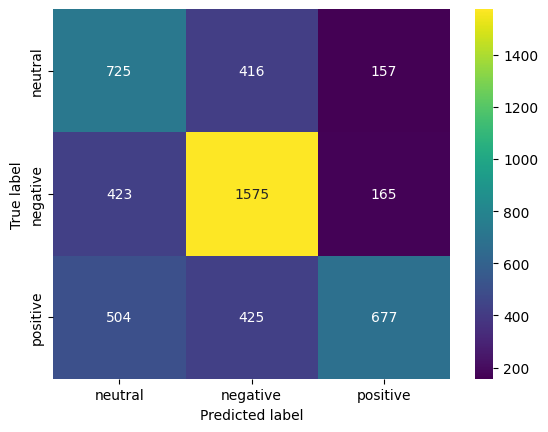

In [30]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'phase2_part4_model.pth')

> Best Accuracy: 60 (Part4 BERT)\
Best f1-score: 69 (Part4 BERT) \
* > Glove word embeddings are context independent- these models output just one vector (embedding) for each word, combining all the different senses of the word into one vector.\
* > That is the one numeric representation of a word regardless of where the words occurs in a sentence and regardless of the different meanings they may have.\
* > BERT can generate different word embeddings for a word that captures the context of a word - that is its position in a sentence.\
* > BERT uses Transformer an attention based model with positional encodings to represent word positions.\
* > we can use word2vec and Glove vectors trained on a large corpus directly for downstream tasks. All we need is the vectors for the words. There is no need for the model itself that was used to train these vectors\
* > in the case of BERT, since they are context dependent, we need the model that was used to train the vectors even after training, since the models generate the vectors for a word based on context.